In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 
root = "/content/drive/MyDrive/final/"
# IF not running in colab, commet above and uncomment below
# root = "./"

!pip install transformers sentencepiece

from transformers             import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AutoConfig,Trainer, TrainingArguments, BertweetTokenizer, BertConfig, RobertaModel,RobertaTokenizer, XLMRobertaTokenizer, XLMRobertaModel
from torch.utils.data         import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics          import f1_score, roc_auc_score, balanced_accuracy_score, mean_squared_error, confusion_matrix, accuracy_score
from sklearn.model_selection  import train_test_split
from collections              import Counter
from tqdm                     import tqdm
from torch.nn.utils.rnn       import pad_sequence

import matplotlib.pyplot   as plt
import torch.nn.functional as F
import numpy  as np
import pandas as pd

import copy
import torch
import os
import random
import re
import gc
import csv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.5 MB/s eta 0:00:00


device(type='cuda')

In [ ]:
class Mod(torch.nn.Module):
  def __init__(self, num_hidden, num_outs):
    super().__init__()
    self.fc1 = torch.nn.Linear(768,num_hidden)    
    self.drop = torch.nn.Dropout(0.33)
    self.hidden = torch.nn.Linear(num_hidden,num_outs)

  def forward(self,x):
    x = torch.nn.functional.relu(self.fc1(x))
    x = self.drop(x)
    return self.hidden(x)

model = Mod(num_hidden = 300, num_outs = 2).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
epochs = 5

117455
0.025050771844887725


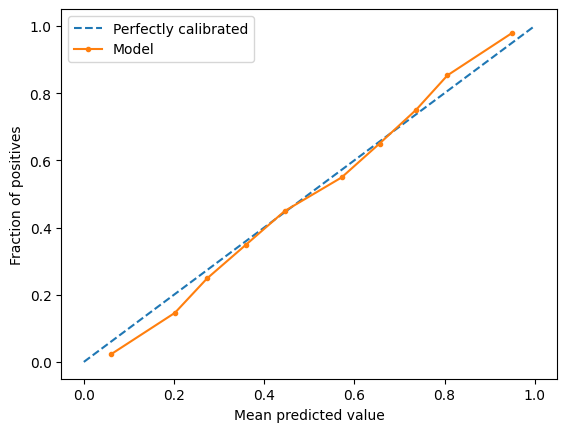

In [ ]:
# to get calibaration curve
import sklearn.calibration
import numpy as np
import matplotlib.pyplot as plt

test2df = pd.read_csv(root + 'CombinedTestEmbed.tsv', delimiter='\t')
from torch import tensor
def converter(x):
    return eval(x)
    
test2df['embedding'] = test2df['embedding'].apply(converter)

testset = TensorDataset(torch.stack(list(test2df['embedding'])), torch.LongTensor(list(test2df['label'])))
testloader = DataLoader(testset)
print(len(testloader))


model.load_state_dict(torch.load(root + "combined_model.pt"))
model.eval()

test_outputs = model(torch.stack(list(test2df['embedding'])))
test_outputs = torch.softmax(test_outputs, dim =2)
test_outputs = test_outputs[:,:,1].cpu()

predictions = test_outputs.detach().numpy().flatten()

# Calculate the calibration curve

bins = np.linspace(0, 1, num=10)
mean_predicted_value, fraction_of_positives = sklearn.calibration.calibration_curve(((test2df['label'])), predictions, n_bins=10)
ece = 0
for i in range(len(mean_predicted_value)):
    ece += np.abs(mean_predicted_value[i] - fraction_of_positives[i])/10
print(ece)



# Plot the calibration curve
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
ax.plot(mean_predicted_value, fraction_of_positives, marker='.', label='Model')
ax.set_xlabel('Mean predicted value')
ax.set_ylabel('Fraction of positives')
ax.set_ylim([-0.05, 1.05])
ax.legend()
plt.show()